In [3]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

In [4]:
def calc_height(t, p, jump = True):
    '''
    isotherm height formular
    z = -R*t0/g * ln(p/p0)
    z = -287.053*t0/9.80665 * ln(p/p0)
    
    polytrop height forumular
    z = t0/L * ((p/p0)**(-L*R/g) -1)
    L = −0.0065 K/m
    R = 287.053 J/(kg K)
    g = 9.80665 m/s2
    z = t0/−0.0065 * ((p/p0)**(0.0065*287.053/9.80665) -1)
    
    international height formular
    z = 288.15/0.0065 * (1- (p/1013.25)**(1/5.255))
    
    '''
    # from: https://www.cesm.ucar.edu/models/cesm1.1/cesm/cesmBbrowser/html_code/cam/tropopause.F90.html
    SHR_CONST_AVOGAD  = 6.02214e26
    SHR_CONST_BOLTZ   = 1.38065e-23
    SHR_CONST_MWDAIR  = 28.966
    SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
    SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
    rair = SHR_CONST_RDAIR

    SHR_CONST_G       = 9.80616
    gravit = SHR_CONST_G

    SHR_CONST_CPDAIR  = 1.00464e3
    cappa        = (SHR_CONST_RGAS/SHR_CONST_MWDAIR)/SHR_CONST_CPDAIR
    cnst_kap = cappa

    cnst_faktor = -gravit/rair
    cnst_ka1    = cnst_kap - 1.
        
    z = []
    for i in range(len(t)):
        
        if i == 0:
            L = -0.0065
            height = t[i]/L * ((p[i]/101325)**(-L*287.053/9.80665) -1)
            z.append(height)
        else:
            if jump:
                if z[i-1] < 11000:
                    L = -0.0065
                else:
                    L = -0.001
            else:                    
                # dt/dz
                pmk= .5 * (p[i-1]**cnst_kap+p[i]**cnst_kap)
                pm = pmk**(1/cnst_kap)               
                a = (t[i-1]-t[i])/(p[i-1]**cnst_kap-p[i]**cnst_kap)
                b = t[i]-(a*p[i]**cnst_kap)
                tm = a * pmk + b               
                dtdp = a * cnst_kap * (pm**cnst_ka1)
                L = cnst_faktor*dtdp*pm/tm # dtdz
#                 if not ((L < 0.05) and (L > -0.05)):
#                     L = -0.0065
                if L == 0:
                    L = -0.001

            height = t[i-1]/L * ((p[i]/p[i-1])**(-L*287.053/9.80665) -1)
            if np.isnan(height):
                print('p: ', p[i])
                print('p-1: ', p[i-1])
                print('t: ', t[i])
                print('t-1: ', t[i-1])
                print('L: ', L)
                z.append(z[-1])
            else:
                z.append(z[-1] + height)
    return z




        

# to gpm
from scipy.integrate import quad

def integrand(x):
    return (6371000 / (6371000 + x))**2
def expint(x):
    return quad(integrand, 0, x,)[0]


In [5]:
def inverse_haversine(lat, lon, distance, direction):
    '''
    distance: [km]
    '''
    lat = numpy.radians(lat)
    lon = numpy.radians(lon)
    d = numpy.array(distance)
    r = 6371 #[km]
    if direction == "NORTH":
        brng = 0.
    elif direction == "EAST":
        brng = 1.5707963267948966
    else:
        return "error - not a valid direction"
    return_lat = numpy.arcsin(numpy.sin(lat) * numpy.cos(d / r) + numpy.cos(lat) * numpy.sin(d / r) * numpy.cos(brng))
    return_lon = lon + numpy.arctan2(numpy.sin(brng) * numpy.sin(d / r) * numpy.cos(lat), numpy.cos(d / r) - numpy.sin(lat) * numpy.sin(return_lat))

    return numpy.degrees(return_lat), numpy.degrees(return_lon)

In [6]:
# from haversine import inverse_haversine, Direction
def transport(lat, lon, u_dist, v_dist):
    '''
    dist: [km]
    '''
    new_lat, new_lon = inverse_haversine(lat, lon, u_dist, "EAST")
    new_lat, new_lon = inverse_haversine(new_lat, new_lon, v_dist, "NORTH")
    return new_lat, new_lon

In [7]:
def trajectory(lat, lon, u, v, pressure, temperature, w_rs = 5.0, wind = 'mean', factor = 1, u_factor = None, v_factor = None, z_variant = 'jump'):
    '''
    w_rs -> radio sonde rising speed
    '''
    if ((u_factor == None) and (v_factor == None)):
        u_factor = factor
        v_factor = factor
    
    if z_variant == 'jump':
        z = calc_height(temperature, pressure, jump = True) # m from K and Pa
    elif z_variant == 'ucar': 
        z = calc_height(temperature, pressure, jump = False) # m from K and Pa
#     print(temperature, pressure)
#     vec_expint = numpy.vectorize(expint)
#     z = vec_expint(z)
    
    lat_displacement = [0.]
    lon_displacement = [0.]
    
    for i in range(len(z)):
        if i == 0:
            new_lat = lat
            new_lon = lon
        else:
            rising_time = (z[i]-z[i-1]) / w_rs
#             print(z[i], z[i-1], z[i]-z[i-1], rising_time)
            status = 400
#             match wind:
#                 case 'mean':
#                     new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000., (np.mean([v[i],v[i-1]]) * rising_time)/1000.)
#                 case 'upper':
#                     new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000., (v[i] * rising_time)/1000.)
#                 case 'lower':
#                     new_lat, new_lon = transport(new_lat, new_lon, (u[i-1] * rising_time)/1000., (v[i-1] * rising_time)/1000.) 
#                 case _:
#                     print('error: not a valid wind request')
            if wind == 'mean':
                new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000. * u_factor, (np.mean([v[i],v[i-1]]) * rising_time)/1000. * v_factor)
            elif wind == 'upper':
                new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000. * u_factor, (v[i] * rising_time)/1000. * v_factor)
            elif wind == 'lower':
                new_lat, new_lon = transport(new_lat, new_lon, (u[i-1] * rising_time)/1000. * u_factor, (v[i-1] * rising_time)/1000. * v_factor) 
            else:
                print('error: not a valid wind request')


            
            lat_displacement.append(lon - new_lon)
            lon_displacement.append(lat - new_lat)
#         lat_displacement.append(new_lat)
#         lon_displacement.append(new_lon)

    return lat_displacement, lon_displacement


---
---
---

In [8]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
bufrfile = sodblist[0]

In [9]:
f = open(bufrfile)

In [10]:
bufr = codes_bufr_new_from_file(f)

# Different factors for wind to distance calculation - different for u and v

In [6]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    
#     true_sum_lon={}
#     true_sum_lat={}
#     rmse_sum_lon={}
#     rmse_sum_lat={}
#     rmse_sum_lon_1={}
#     rmse_sum_lat_1={}
#     rmse_sum_lon_2={}
#     rmse_sum_lat_2={}
#     for i in [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]:
#         true_sum_lon[i] = []
#         true_sum_lat[i] = []
#         rmse_sum_lon[i] = []
#         rmse_sum_lat[i] = []
#         rmse_sum_lon_1[i] = []
#         rmse_sum_lat_1[i] = []
#         rmse_sum_lon_2[i] = []
#         rmse_sum_lat_2[i] = []
    rmse_sum_lat = []
    rmse_sum_lon = []
    rmse_sum_lat_1 = []
    rmse_sum_lon_1 = []
    rmse_sum_lat_2 = []
    rmse_sum_lon_2 = []
    
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
            ##print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

            # print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#             print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            data = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
        if cont:
            if data.pressure[0] < 40000:
                u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
                data['u'] = u
                v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
                data['v'] = v
                data = data[data.airTemperature < 350]
                data = data[data.airTemperature > 180]
                
                true_latd = data.latitudeDisplacement
                true_lond = data.longitudeDisplacement


                lat_displacement_100, lon_displacement_100 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), factor=1)
                lat_displacement_test1, lon_displacement_test1 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), u_factor=0.9, v_factor = 1.1)
                lat_displacement_test2, lon_displacement_test2 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), u_factor=0.85, v_factor = 1.15)

#                 reduced = data[numpy.isin(data.pressure, [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000])]
#                 reduced_lat_displacement, reduced_lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))

                print(output['lat'], output['lon'], output['datum'], output['timePeriod'])
                plt.plot(data.pressure,np.array(lat_displacement_100),color = 'blue', label='calc lat disp 100')
                plt.plot(data.pressure,np.array(lon_displacement_100),color = 'red', label='calc lon disp 100')
#                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                plt.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
                plt.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
                plt.title('height calc different wind application factors')
                plt.legend()
                plt.grid()
                plt.show()
                plt.close()
                rmse_sum_lat.append(np.sqrt(np.nanmean((np.array(lat_displacement_100)-true_latd)**2)))
                rmse_sum_lon.append(np.sqrt(np.nanmean((np.array(lon_displacement_100)-true_lond)**2)))
                print('lat disp rmse: ',rmse_sum_lat[-1])
                print('lon disp rmse: ',rmse_sum_lon[-1])

            
                plt.plot(data.pressure,np.array(lat_displacement_test1),color = 'blue', label='calc lat disp test1')
                plt.plot(data.pressure,np.array(lon_displacement_test1),color = 'red', label='calc lon disp test1')
#                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                plt.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
                plt.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
                plt.title('height calc different wind application factors')
                plt.legend()
                plt.grid()
                plt.show()
                plt.close()
                rmse_sum_lat_1.append(np.sqrt(np.nanmean((np.array(lat_displacement_test1)-true_latd)**2)))
                rmse_sum_lon_1.append(np.sqrt(np.nanmean((np.array(lon_displacement_test1)-true_lond)**2)))
                print('lat disp rmse: ',rmse_sum_lat_1[-1])
                print('lon disp rmse: ',rmse_sum_lon_1[-1])
                
                print(output['lat'], output['lon'], output['datum'], output['timePeriod'])
                plt.plot(data.pressure,np.array(lat_displacement_test2),color = 'blue', label='calc lat disp test2')
                plt.plot(data.pressure,np.array(lon_displacement_test2),color = 'red', label='calc lon disp test2')
#                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                plt.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
                plt.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
                plt.title('height calc different wind application factors')
                plt.legend()
                plt.grid()
                plt.show()
                plt.close()
                rmse_sum_lat_2.append(np.sqrt(np.nanmean((np.array(lat_displacement_test2)-true_latd)**2)))
                rmse_sum_lon_2.append(np.sqrt(np.nanmean((np.array(lon_displacement_test2)-true_lond)**2)))
                print('lat disp rmse: ',rmse_sum_lat_2[-1])
                print('lon disp rmse: ',rmse_sum_lon_2[-1])
                
# not enought std pressure levels available for bufr to make this work                
#                 plev = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
#                 for i in plev:
#                     true_latd = data.latitudeDisplacement[data.pressure == i]
#                     true_lond = data.longitudeDisplacement[data.pressure == i]
#                     i_latd = np.array(lat_displacement_100)[data.pressure == i]
#                     i_lond = np.array(lon_displacement_100)[data.pressure == i]
#                     i_latd_1 = np.array(lat_displacement_test1)[data.pressure == i]
#                     i_lond_1 = np.array(lon_displacement_test1)[data.pressure == i]
#                     i_latd_2 = np.array(lat_displacement_test2)[data.pressure == i]
#                     i_lond_2 = np.array(lon_displacement_test2)[data.pressure == i]
                    
#                     if len(true_latd) == 1:
#                         true_sum_lat[i].append(float(true_latd))           
#                     else:
#                         true_sum_lat[i].append(np.nan)
#                     if len(true_lond) == 1:
#                         true_sum_lon[i].append(float(true_lond))       
#                     else:
#                         true_sum_lon[i].append(np.nan)
                    
#                     if len(i_latd) == 1:
#                         rmse_sum_lat[i].append(float(i_latd))           
#                     else:
#                         rmse_sum_lat[i].append(np.nan)
#                     if len(i_lond) == 1:
#                         rmse_sum_lon[i].append(float(i_lond))       
#                     else:
#                         rmse_sum_lon[i].append(np.nan)
                        
#                     if len(i_latd_1) == 1:
#                         rmse_sum_lat[i].append(float(i_latd_1))
#                     else:
#                         rmse_sum_lat[i].append(np.nan)
                        
#                     if len(i_lond_1) == 1:
#                         rmse_sum_lon[i].append(float(i_lond_1))
#                     else:
#                         rmse_sum_lon[i].append(np.nan)
                    
#                     if len(i_latd_2) == 1:
#                         rmse_sum_lat[i].append(float(i_latd_2))
#                     else:
#                         rmse_sum_lat[i].append(np.nan)
                        
#                     if len(i_lond_2) == 1:
#                         rmse_sum_lon[i].append(float(i_lond_2))
#                     else:
#                         rmse_sum_lon[i].append(np.nan)
                        
                                                
                plt.plot(data.pressure,np.array(data.latitudeDisplacement - lat_displacement_100), label='diff lat disp 100')
                plt.plot(data.pressure,np.array(data.latitudeDisplacement - lat_displacement_test1), label='diff lat disp test1')
                plt.plot(data.pressure,np.array(data.latitudeDisplacement - lat_displacement_test2), label='diff lat disp test2')
                plt.title('height calc [v] - latitude differences')
                plt.legend()
                plt.grid()
                plt.show()
                plt.close()
                
                plt.plot(data.pressure,np.array(data.longitudeDisplacement - lon_displacement_100), label='diff lon disp 100')
                plt.plot(data.pressure,np.array(data.longitudeDisplacement - lon_displacement_test1), label='diff lon disp test1')
                plt.plot(data.pressure,np.array(data.longitudeDisplacement - lon_displacement_test2), label='diff lon disp test2')
                plt.title('height calc [u] - longitude differences')
                plt.legend()
                plt.grid()
                plt.show()
                plt.close()
                
                print('----------------')
                
                bc += 1
#         except:
#             pass
        if bc > 30:
            break
    print(rmse_sum_lat)
    print('data set 0: ',np.median(rmse_sum_lat), np.median(rmse_sum_lon))
    print('data set 1: ',np.median(rmse_sum_lat_1), np.median(rmse_sum_lon_1))
    print('data set 2: ',np.median(rmse_sum_lat_2), np.median(rmse_sum_lon_2))
        
    return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


# More ascents

In [15]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    
    
    rmse_total_lat = []
    rmse_total_lon = []
    rmse_total_lat_1 = []
    rmse_total_lon_1 = []
    
    rmse_sum_lon_1={}
    rmse_sum_lat_1={}
    rmse_sum_lon_2={}
    rmse_sum_lat_2={}
    rms_sum_lon_1={}
    rms_sum_lat_1={}
    rms_sum_lon_2={}
    rms_sum_lat_2={}
    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        rmse_sum_lon_1[i] = []
        rmse_sum_lat_1[i] = []
        rmse_sum_lon_2[i] = []
        rmse_sum_lat_2[i] = []
        rms_sum_lon_1[i] = []
        rms_sum_lat_1[i] = []
        rms_sum_lon_2[i] = []
        rms_sum_lat_2[i] = []
        
    while 1:
        try:
            # get handle for message
            bufr = codes_bufr_new_from_file(f)
            if bufr is None:
                break
            # we need to instruct ecCodes to expand all the descriptors
            # i.e. unpack the data section
            if codes_get_array(bufr,'dataSubCategory')[0]!=109:
                codes_release(bufr)
                continue
            codes_set(bufr, 'unpack', 1)
            # get all the timePeriods
            iterid = codes_bufr_keys_iterator_new(bufr)

            # loop over the keys
            #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
                ##print (codes_get_array(bufr,'dataSubCategory')[0])
                #codes_release(bufr)
                #continue
            hires=False
            while codes_bufr_keys_iterator_next(iterid):

                # print key name
                keyname = codes_bufr_keys_iterator_get_name(iterid)
    #             print(keyname,codes_get_array(bufr,keyname))
                #if keyname in ['#1#blockNumber','#1#stationNumber']:
                    #print (keyname,codes_get_array(bufr,keyname))
                if 'latitudeDisplacement' in keyname:
                    hires=True
            if not hires:
                codes_bufr_keys_iterator_delete(iterid)
                continue
            ## delete the key iterator
            codes_bufr_keys_iterator_delete(iterid)
            output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
            output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
            output['pressure'] = codes_get_array(bufr, "pressure")
            output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
            output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
            output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
            output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
            output['airTemperature'] = codes_get_array(bufr, "airTemperature")
            dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
            output['windDirection'] = codes_get_array(bufr, "windDirection")
            output['windSpeed'] = codes_get_array(bufr, "windSpeed")
            output['lat'] = codes_get(bufr, "latitude")
            output['lon'] = codes_get(bufr, "longitude")
            output['alt'] = float(codes_get(bufr, "heightOfStation"))
            output['blockNumber'] = codes_get(bufr, "blockNumber")
            output['stationNumber'] = codes_get(bufr, "stationNumber")
            try:
                data = pd.DataFrame.from_dict(output)
                cont = True
            except:
                cont = False
            if cont:
                if data.pressure[0] < 40000:
                    u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
                    data['u'] = u
                    v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
                    data['v'] = v
                    data = data[data.airTemperature < 350]
                    data = data[data.airTemperature > 180]
                    data = data.drop_duplicates(['pressure'])

                    true_latd = data.latitudeDisplacement
                    true_lond = data.longitudeDisplacement


                    lat_displacement_100, lon_displacement_100 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', factor=1)
                    lat_displacement_test1, lon_displacement_test1 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', u_factor=0.83, v_factor = 1.15)

    #                 reduced = data[numpy.isin(data.pressure, [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000])]
    #                 reduced_lat_displacement, reduced_lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))


                    rmse_total_lat.append(np.sqrt(np.nanmean((np.array(lat_displacement_100)-true_latd)**2)))
                    rmse_total_lon.append(np.sqrt(np.nanmean((np.array(lon_displacement_100)-true_lond)**2)))
                    rms_total_lat = (np.sqrt(np.nanmean((np.array(lat_displacement_100))**2)))
                    rms_total_lon = (np.sqrt(np.nanmean((np.array(lon_displacement_100))**2)))
                    if (rmse_total_lat[-1] > 3) or (rmse_total_lon[-1] > 3):
                        print('not a valid station')
                        print('lat: ', rms_total_lat, ' / ', rmse_total_lat[-1])
                        print('lon: ', rms_total_lon, ' / ', rmse_total_lon[-1])
                        continue


                    print(output['lat'], output['lon'], output['datum'], output['timePeriod'])
                    for i in range(len(stdplevs)):
                        if i > 0:
                            a = np.array(lon_displacement_100)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                            rms_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                            a = np.array(lat_displacement_100)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                            rms_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                            a = np.array(lon_displacement_test1)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                            rms_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                            a = np.array(lat_displacement_test1)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                            rms_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

    #                 fig, ax1 = maplt.subplots()
    #                 ax1.plot(data.pressure,np.array(lat_displacement_100),color = 'blue', label='calc lat disp 100')
    #                 ax1.plot(data.pressure,np.array(lon_displacement_100),color = 'red', label='calc lon disp 100')
    # #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
    # #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
    #                 ax1.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
    #                 ax1.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
    #                 ax1.set_xlabel('pressure (Pa)')
    #                 ax1.set_ylabel('displacement (°)')
    #                 ax1.tick_params(axis='y')

    # #                 ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    # # #                 ax2.plot(data.pressure,data.airTemperature,color = 'orange', label='temperature')
    # # #                 ax2.set_ylabel('temperature (K)')  # we already handled the x-label with ax1
    # #                 ax2.plot(data.pressure,data.u, label='u')
    # #                 ax2.plot(data.pressure,data.v, label='v')
    # #                 ax2.set_ylabel('u/v (m/s)')  # we already handled the x-label with ax1
    # #                 ax2.tick_params(axis='y',)

    #                 fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #                 maplt.title('height calc different wind application factors')
    #                 maplt.legend()
    #                 maplt.grid()
    #                 maplt.show()
    #                 maplt.close()

                    print('lat disp rmse: ',rmse_total_lat[-1])
                    print('lon disp rmse: ',rmse_total_lon[-1])



    #                 fig, ax1 = maplt.subplots()
    #                 ax1.plot(data.pressure,np.array(lat_displacement_test1),color = 'blue', label='calc lat disp test1')
    #                 ax1.plot(data.pressure,np.array(lon_displacement_test1),color = 'red', label='calc lon disp test1')
    # #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
    # #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
    #                 ax1.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
    #                 ax1.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
    #                 ax1.set_xlabel('pressure (Pa)')
    #                 ax1.set_ylabel('displacement (°)')
    #                 ax1.tick_params(axis='y')

    # #                 ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    # # #                 ax2.plot(data.pressure,data.airTemperature,color = 'orange', label='temperature')
    # # #                 ax2.set_ylabel('temperature (K)')  # we already handled the x-label with ax1
    # #                 ax2.plot(data.pressure,data.u, label='u')
    # #                 ax2.plot(data.pressure,data.v, label='v')
    # #                 ax2.set_ylabel('u/v (m/s)')  # we already handled the x-label with ax1
    # #                 ax2.tick_params(axis='y',)

    #                 fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #                 maplt.title('height calc different wind application factors')
    #                 maplt.legend()
    #                 maplt.grid()
    #                 maplt.show()
    #                 maplt.close()

                    rmse_total_lat_1.append(np.sqrt(np.nanmean((np.array(lat_displacement_test1)-true_latd)**2)))
                    rmse_total_lon_1.append(np.sqrt(np.nanmean((np.array(lon_displacement_test1)-true_lond)**2)))
                    print('lat disp rmse: ',rmse_total_lat_1[-1])
                    print('lon disp rmse: ',rmse_total_lon_1[-1])


                    print('----------------')

                    bc += 1
        except:
            pass
        if bc > 100:
            break
    
    rmse_lat_1 = []
    rmse_lon_1 = []
    rmse_lat_2 = []
    rmse_lon_2 = []
    
    rms_lat_1 = []
    rms_lon_1 = []
    rms_lat_2 = []
    rms_lon_2 = []
    for i in range(len(stdplevs)):
        if i > 0:
            rmse_lat_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_1[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_1[-1])
            rmse_lon_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_1[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_1[-1])
            rmse_lat_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_2[stdplevs[i]])**2))))
            print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_2[-1])
            rmse_lon_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_2[stdplevs[i]])**2))))
            print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_2[-1])
            
            rms_lat_1.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_1[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
            rms_lon_1.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_1[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])
            rms_lat_2.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_2[stdplevs[i]])**2))))
            print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_2[-1])
            rms_lon_2.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_2[stdplevs[i]])**2))))
            print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_2[-1])
            
    fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
    ax1[0].plot(stdplevs[1:],np.array(rmse_lat_1),color = 'blue',alpha = 0.3, label='lat RMSE disp 1')
    ax1[0].plot(stdplevs[1:],np.array(rmse_lat_2),color = 'blue', label='lat RMSE disp 2')
    ax1[0].plot(stdplevs[1:],np.array(rms_lat_1),color = 'blue', linestyle = 'dotted', alpha = 0.3, label='lat RMS disp 1')
    ax1[0].plot(stdplevs[1:],np.array(rms_lat_2),color = 'blue', linestyle = 'dotted', label='lat RMS disp 2')
    ax1[0].set_xlabel('pressure (Pa)')
    ax1[0].set_ylabel('RMSE/RMS of displacement')
    ax1[0].legend()
    ax1[0].grid()
    maplt.title('LEVEL RMSE/RMS for Displacement')
    ax1[1].plot(stdplevs[1:],np.array(rmse_lon_1),color = 'red',alpha = 0.3, label='lon RMSE disp 1')
    ax1[1].plot(stdplevs[1:],np.array(rmse_lon_2),color = 'red', label='lon RMSE disp 2')
    ax1[1].plot(stdplevs[1:],np.array(rms_lon_1),color = 'red', linestyle = 'dotted', alpha = 0.3, label='lon RMS disp 1')
    ax1[1].plot(stdplevs[1:],np.array(rms_lon_2),color = 'red', linestyle = 'dotted', label='lon RMS disp 2')
    ax1[1].set_xlabel('pressure (Pa)')
    ax1[1].set_ylabel('RMSE/RMS of displacement')
    ax1[1].legend()
    ax1[1].grid()
    maplt.title('LEVEL RMSE/RMS for Displacement')
    maplt.show()
    maplt.close()
    
    print('data set 1: ',np.median(rmse_total_lat), np.median(rmse_total_lon))
    print('data set 2: ',np.median(rmse_total_lat_1), np.median(rmse_total_lon_1))
        
    return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


In [ ]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202012' mode='r' encoding='UTF-8'>
43.06 -108.48 19201130.0 230100.0
lat disp rmse:  0.00498653684496597
lon disp rmse:  0.07086273256490315
lat disp rmse:  0.0052443999719619045
lon disp rmse:  0.03425626472122954
----------------
35.040000000000006 -106.62 19201130.0 230300.0
lat disp rmse:  0.02318725593415237
lon disp rmse:  0.05166604816216149
lat disp rmse:  0.0036127781678991513
lon disp rmse:  0.022875329983819418
----------------
37.760000000000005 -99.97000000000001 19201130.0 230100.0
lat disp rmse:  0.06780080711199972
lon disp rmse:  0.022470666260192784
lat disp rmse:  0.017014257339044717
lon disp rmse:  0.005766063995573028
----------------
40.86000000000001 -115.74000000000001 19201130.0 230300.0
lat disp rmse:  0.05444139474975005
lon disp rmse:  0.09231758421960976
lat disp rmse:  0.015870483826508606
lon disp rmse:  0.04039571847578099
----------------
39.120000000000005 -108.53000000000002 19201130.0 23010

In [11]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    
    
    rmse_total_lat = []
    rmse_total_lon = []
    rmse_total_lat_1 = []
    rmse_total_lon_1 = []
    
    rmse_sum_lon_1={}
    rmse_sum_lat_1={}
    rmse_sum_lon_2={}
    rmse_sum_lat_2={}
    rms_sum_lon_1={}
    rms_sum_lat_1={}
    rms_sum_lon_2={}
    rms_sum_lat_2={}
    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        rmse_sum_lon_1[i] = []
        rmse_sum_lat_1[i] = []
        rmse_sum_lon_2[i] = []
        rmse_sum_lat_2[i] = []
        rms_sum_lon_1[i] = []
        rms_sum_lat_1[i] = []
        rms_sum_lon_2[i] = []
        rms_sum_lat_2[i] = []
        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
            ##print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

            # print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#             print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            data = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
        if cont:
            if data.pressure[0] < 40000:
                u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
                data['u'] = u
                v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
                data['v'] = v
                data = data[data.airTemperature < 350]
                data = data[data.airTemperature > 180]
                data = data.drop_duplicates(['pressure'])
                
                true_latd = data.latitudeDisplacement
                true_lond = data.longitudeDisplacement


                lat_displacement_100, lon_displacement_100 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', factor=1)
                lat_displacement_test1, lon_displacement_test1 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', u_factor=0.83, v_factor = 1.15)
                
#                 reduced = data[numpy.isin(data.pressure, [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000])]
#                 reduced_lat_displacement, reduced_lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))


                rmse_total_lat.append(np.sqrt(np.nanmean((np.array(lat_displacement_100)-true_latd)**2)))
                rmse_total_lon.append(np.sqrt(np.nanmean((np.array(lon_displacement_100)-true_lond)**2)))
                if (rmse_total_lat[-1] > 3) or (rmse_total_lon[-1] > 3):
                    print('not a valid station')
                    continue
    
    
                print(output['lat'], output['lon'], output['datum'], output['timePeriod'])
                for i in range(len(stdplevs)):
                    if i > 0:
                        a = np.array(lon_displacement_100)
                        a[data.pressure < stdplevs[i]] = np.nan
                        a[data.pressure >= stdplevs[i-1]] = np.nan
                        rmse_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                        rms_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))
                        
                        a = np.array(lat_displacement_100)
                        a[data.pressure < stdplevs[i]] = np.nan
                        a[data.pressure >= stdplevs[i-1]] = np.nan
                        rmse_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                        rms_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))
                        
                        a = np.array(lon_displacement_test1)
                        a[data.pressure < stdplevs[i]] = np.nan
                        a[data.pressure >= stdplevs[i-1]] = np.nan
                        rmse_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                        rms_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))
                        
                        a = np.array(lat_displacement_test1)
                        a[data.pressure < stdplevs[i]] = np.nan
                        a[data.pressure >= stdplevs[i-1]] = np.nan
                        rmse_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                        rms_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))
    
                fig, ax1 = maplt.subplots()
                ax1.plot(data.pressure,np.array(lat_displacement_100),color = 'blue', label='calc lat disp 100')
                ax1.plot(data.pressure,np.array(lon_displacement_100),color = 'red', label='calc lon disp 100')
#                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                ax1.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
                ax1.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
                ax1.set_xlabel('pressure (Pa)')
                ax1.set_ylabel('displacement (°)')
                ax1.tick_params(axis='y')

#                 ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# #                 ax2.plot(data.pressure,data.airTemperature,color = 'orange', label='temperature')
# #                 ax2.set_ylabel('temperature (K)')  # we already handled the x-label with ax1
#                 ax2.plot(data.pressure,data.u, label='u')
#                 ax2.plot(data.pressure,data.v, label='v')
#                 ax2.set_ylabel('u/v (m/s)')  # we already handled the x-label with ax1
#                 ax2.tick_params(axis='y',)

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('height calc different wind application factors')
                maplt.legend()
                maplt.grid()
                maplt.show()
                maplt.close()
                
                print('lat disp rmse: ',rmse_total_lat[-1])
                print('lon disp rmse: ',rmse_total_lon[-1])
                if (rmse_total_lat[-1] > 1) or (rmse_total_lon[-1] > 1):
                    continue
                

                fig, ax1 = maplt.subplots()
                ax1.plot(data.pressure,np.array(lat_displacement_test1),color = 'blue', label='calc lat disp test1')
                ax1.plot(data.pressure,np.array(lon_displacement_test1),color = 'red', label='calc lon disp test1')
#                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                ax1.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
                ax1.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
                ax1.set_xlabel('pressure (Pa)')
                ax1.set_ylabel('displacement (°)')
                ax1.tick_params(axis='y')

#                 ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# #                 ax2.plot(data.pressure,data.airTemperature,color = 'orange', label='temperature')
# #                 ax2.set_ylabel('temperature (K)')  # we already handled the x-label with ax1
#                 ax2.plot(data.pressure,data.u, label='u')
#                 ax2.plot(data.pressure,data.v, label='v')
#                 ax2.set_ylabel('u/v (m/s)')  # we already handled the x-label with ax1
#                 ax2.tick_params(axis='y',)

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('height calc different wind application factors')
                maplt.legend()
                maplt.grid()
                maplt.show()
                maplt.close()
                
                rmse_total_lat_1.append(np.sqrt(np.nanmean((np.array(lat_displacement_test1)-true_latd)**2)))
                rmse_total_lon_1.append(np.sqrt(np.nanmean((np.array(lon_displacement_test1)-true_lond)**2)))
                print('lat disp rmse: ',rmse_total_lat_1[-1])
                print('lon disp rmse: ',rmse_total_lon_1[-1])
                                                
                
                print('----------------')
                
                bc += 1
#         except:
#             pass
        if bc > 30:
            break
    
    rmse_lat_1 = []
    rmse_lon_1 = []
    rmse_lat_2 = []
    rmse_lon_2 = []
    
    rms_lat_1 = []
    rms_lon_1 = []
    rms_lat_2 = []
    rms_lon_2 = []
    for i in range(len(stdplevs)):
        if i > 0:
            rmse_lat_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_1[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_1[-1])
            rmse_lon_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_1[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_1[-1])
            rmse_lat_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_2[stdplevs[i]])**2))))
            print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_2[-1])
            rmse_lon_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_2[stdplevs[i]])**2))))
            print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_2[-1])
            
            rms_lat_1.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_1[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
            rms_lon_1.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_1[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])
            rms_lat_2.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_2[stdplevs[i]])**2))))
            print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_2[-1])
            rms_lon_2.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_2[stdplevs[i]])**2))))
            print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_2[-1])
            
    fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
    ax1[0].plot(stdplevs[1:],np.array(rmse_lat_1),color = 'blue',alpha = 0.3, label='lat RMSE disp 1')
    ax1[0].plot(stdplevs[1:],np.array(rmse_lat_2),color = 'blue', label='lat RMSE disp 2')
    ax1[0].plot(stdplevs[1:],np.array(rms_lat_1),color = 'blue', linestyle = 'dotted', alpha = 0.3, label='lat RMS disp 1')
    ax1[0].plot(stdplevs[1:],np.array(rms_lat_2),color = 'blue', linestyle = 'dotted', label='lat RMS disp 2')
    ax1[0].set_xlabel('pressure (Pa)')
    ax1[0].set_ylabel('RMSE/RMS of displacement')
    ax1[0].legend()
    ax1[0].grid()
    maplt.title('LEVEL RMSE/RMS for Displacement')
    ax1[1].plot(stdplevs[1:],np.array(rmse_lon_1),color = 'red',alpha = 0.3, label='lon RMSE disp 1')
    ax1[1].plot(stdplevs[1:],np.array(rmse_lon_2),color = 'red', label='lon RMSE disp 2')
    ax1[1].plot(stdplevs[1:],np.array(rms_lon_1),color = 'red', linestyle = 'dotted', alpha = 0.3, label='lon RMS disp 1')
    ax1[1].plot(stdplevs[1:],np.array(rms_lon_2),color = 'red', linestyle = 'dotted', label='lon RMS disp 2')
    ax1[1].set_xlabel('pressure (Pa)')
    ax1[1].set_ylabel('RMSE/RMS of displacement')
    ax1[1].legend()
    ax1[1].grid()
    maplt.title('LEVEL RMSE/RMS for Displacement')
    maplt.show()
    maplt.close()
    
    print('data set 1: ',np.median(rmse_total_lat), np.median(rmse_total_lon))
    print('data set 2: ',np.median(rmse_total_lat_1), np.median(rmse_total_lon_1))
        
    return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202012' mode='r' encoding='UTF-8'>
43.06 -108.48 19201130.0 230100.0


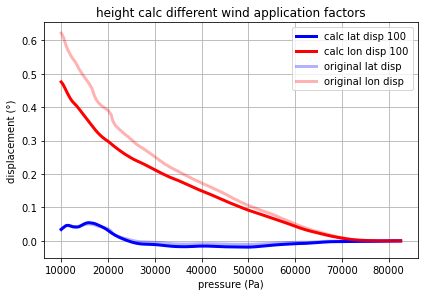

lat disp rmse:  0.00498653684496597
lon disp rmse:  0.07086273256490315


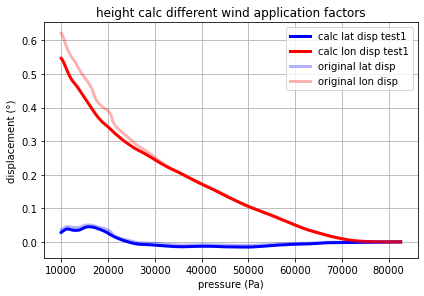

lat disp rmse:  0.0052443999719619045
lon disp rmse:  0.03425626472122954
----------------
35.040000000000006 -106.62 19201130.0 230300.0


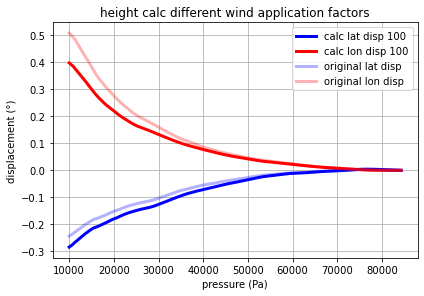

lat disp rmse:  0.02318725593415237
lon disp rmse:  0.05166604816216149


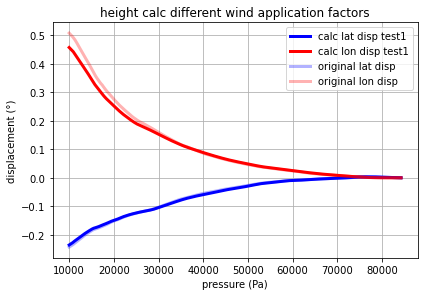

lat disp rmse:  0.0036127781678991513
lon disp rmse:  0.022875329983819418
----------------
37.760000000000005 -99.97000000000001 19201130.0 230100.0


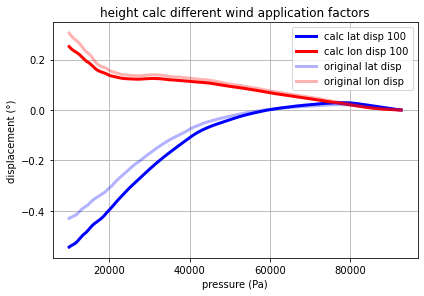

lat disp rmse:  0.06780080711199972
lon disp rmse:  0.022470666260192784


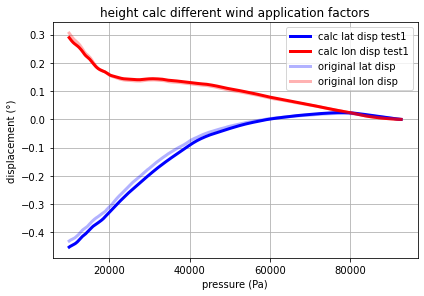

lat disp rmse:  0.017014257339044717
lon disp rmse:  0.005766063995573028
----------------
40.86000000000001 -115.74000000000001 19201130.0 230300.0


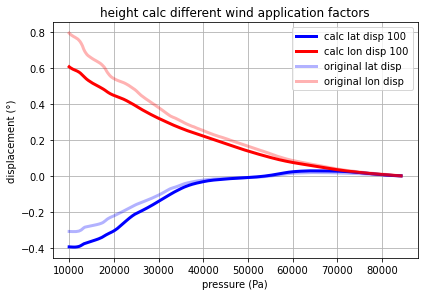

lat disp rmse:  0.05444139474975005
lon disp rmse:  0.09231758421960976


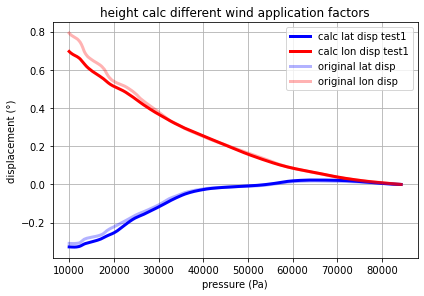

lat disp rmse:  0.015870483826508606
lon disp rmse:  0.04039571847578099
----------------
39.120000000000005 -108.53000000000002 19201130.0 230100.0


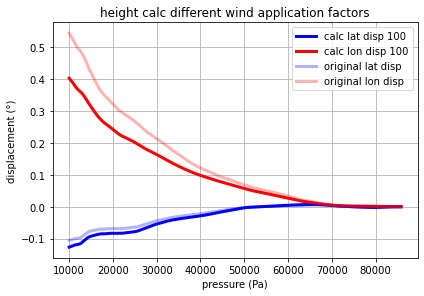

lat disp rmse:  0.011617657626388615
lon disp rmse:  0.06943284114807197


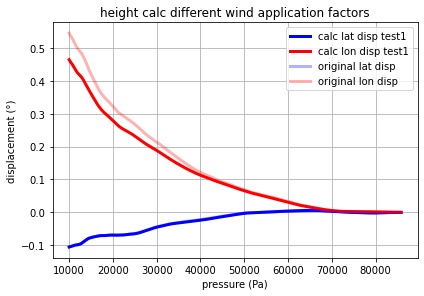

lat disp rmse:  0.0008567447252423573
lon disp rmse:  0.03856413219411597
----------------
39.42 -83.82000000000001 19201130.0 230500.0


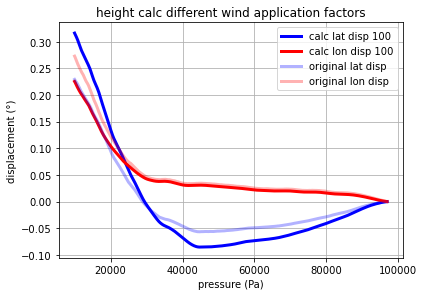

lat disp rmse:  0.041859085661555315
lon disp rmse:  0.020176167884819966


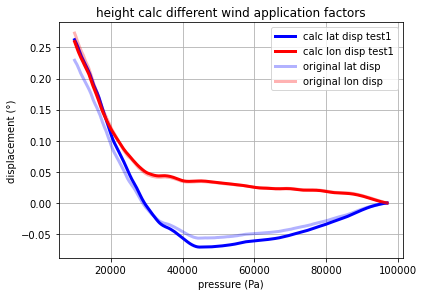

lat disp rmse:  0.017118669542169212
lon disp rmse:  0.005284743240174432
----------------
40.150000000000006 -89.34 19201130.0 230100.0


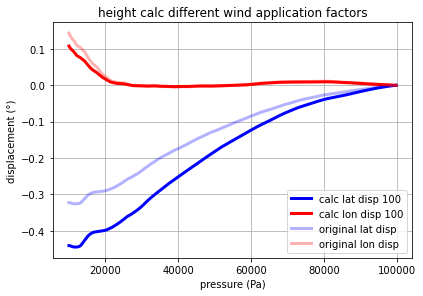

lat disp rmse:  0.0865527380053849
lon disp rmse:  0.012776691250682702


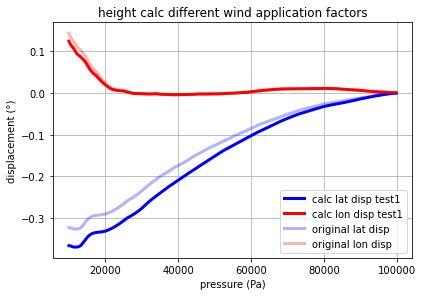

lat disp rmse:  0.0341422877892504
lon disp rmse:  0.007455402341653675
----------------
13.48 144.79000000000002 19201130.0 230100.0


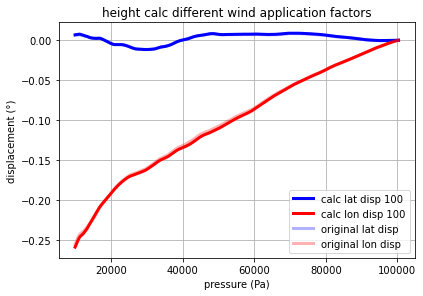

lat disp rmse:  0.0003719870487845598
lon disp rmse:  0.0019087156778020572


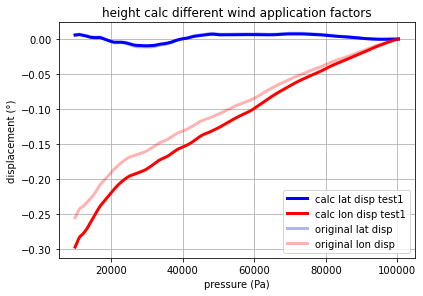

lat disp rmse:  0.000875005309503114
lon disp rmse:  0.024371368746628805
----------------
40.53 -80.22000000000001 19201130.0 230800.0


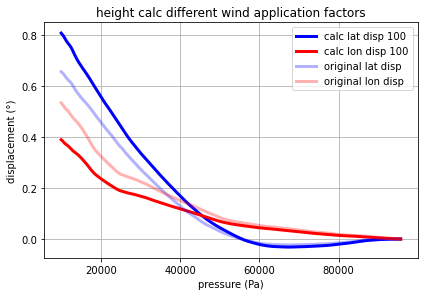

lat disp rmse:  0.07934810175040206
lon disp rmse:  0.0732179600223062


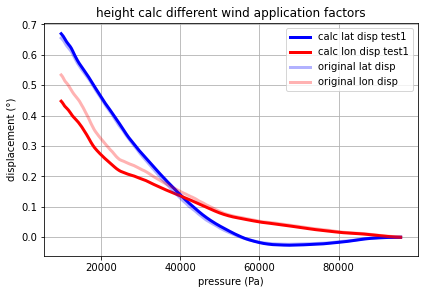

lat disp rmse:  0.007228703034713357
lon disp rmse:  0.04320035844125975
----------------
27.71 -82.4 19201130.0 230300.0


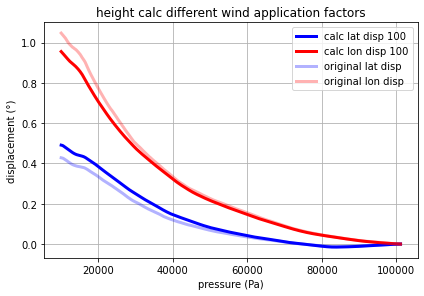

lat disp rmse:  0.03746812395278179
lon disp rmse:  0.04703097478087676


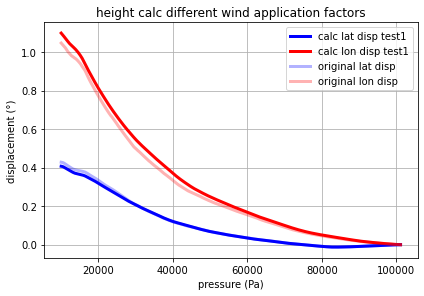

lat disp rmse:  0.010370966585329275
lon disp rmse:  0.03486381281776224
----------------
34.84 -92.26 19201130.0 231100.0


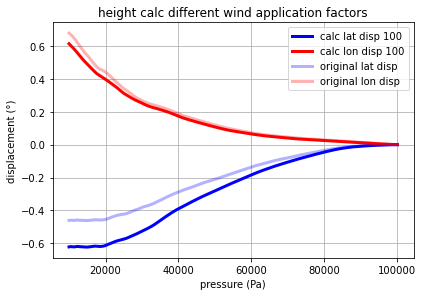

lat disp rmse:  0.11891145650095268
lon disp rmse:  0.03264043158753544


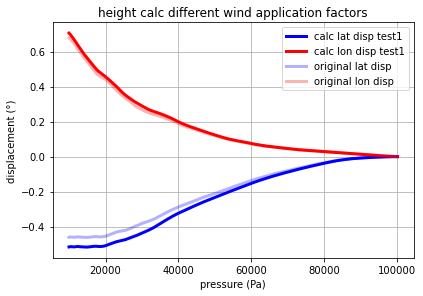

lat disp rmse:  0.04155266695527802
lon disp rmse:  0.015081984324851092
----------------
36.25 -86.56 19201130.0 230700.0


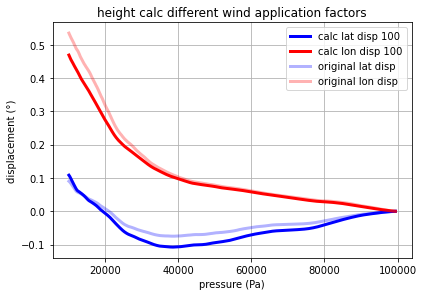

lat disp rmse:  0.020427525736876506
lon disp rmse:  0.03375081440819628


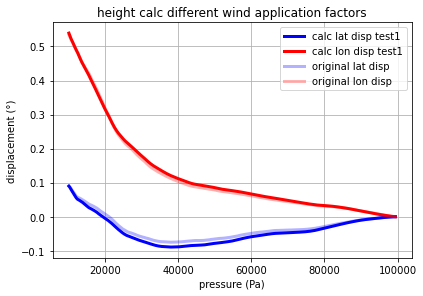

lat disp rmse:  0.010623533352831574
lon disp rmse:  0.005798514425500542
----------------
35.230000000000004 -101.71000000000001 19201130.0 230600.0


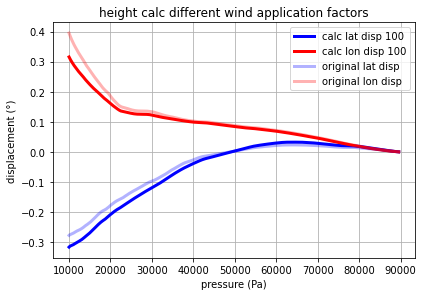

lat disp rmse:  0.0241064439245392
lon disp rmse:  0.029641660858303834


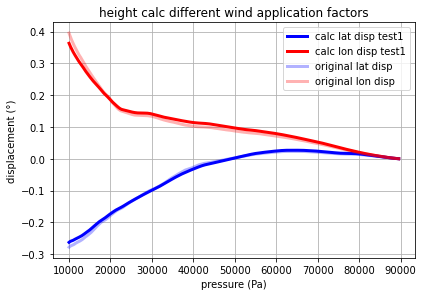

lat disp rmse:  0.006769394841289102
lon disp rmse:  0.01154738312549018
----------------
47.68000000000001 -117.63000000000001 19201130.0 230400.0


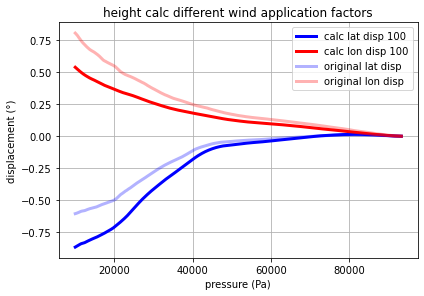

lat disp rmse:  0.15761268016758578
lon disp rmse:  0.14011579786819195


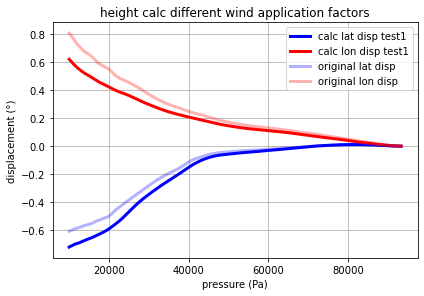

lat disp rmse:  0.07037793368494263
lon disp rmse:  0.0959308014714192
----------------
42.940000000000005 -78.72000000000001 19201130.0 231300.0


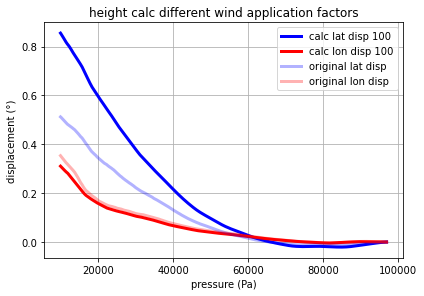

lat disp rmse:  0.1897747333473205
lon disp rmse:  0.018159476947631318


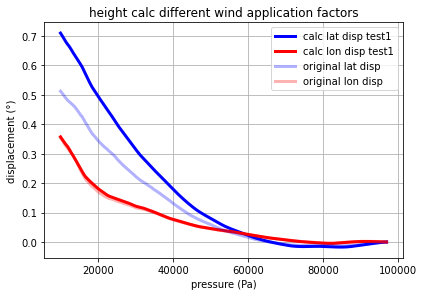

lat disp rmse:  0.11059705874320121
lon disp rmse:  0.004808809349829735
----------------
27.78 -97.51 19201130.0 230800.0


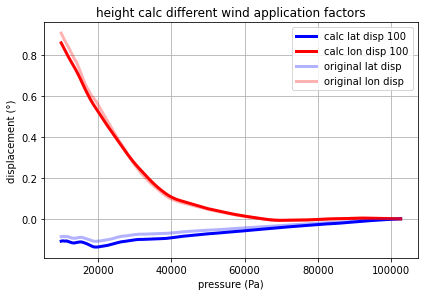

lat disp rmse:  0.020884582455344594
lon disp rmse:  0.022433735751924085


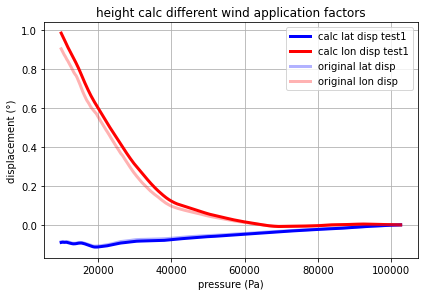

lat disp rmse:  0.005158152032376489
lon disp rmse:  0.043029380628441055
----------------
31.94 -102.19000000000001 19201130.0 230300.0


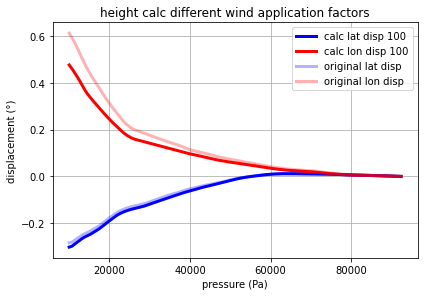

lat disp rmse:  0.009999734133694276
lon disp rmse:  0.06074310719153026


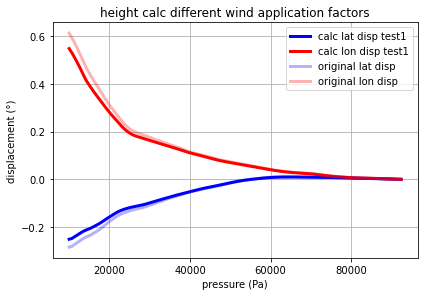

lat disp rmse:  0.016377956407506
lon disp rmse:  0.028826291220636863
----------------
32.32 -90.08000000000001 19201130.0 230600.0


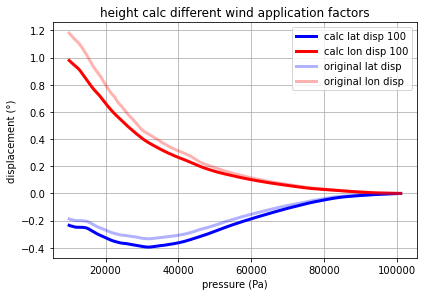

lat disp rmse:  0.04693739402559307
lon disp rmse:  0.10519892249877577


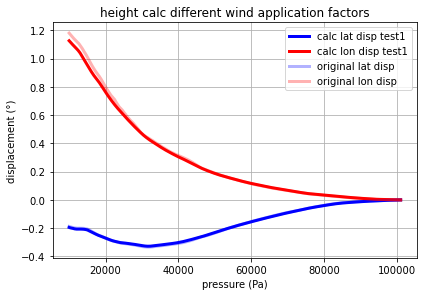

lat disp rmse:  0.004211083517511781
lon disp rmse:  0.02861077299481279
----------------
44.85 -93.56 19201130.0 230300.0


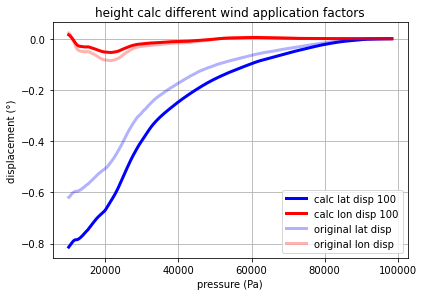

lat disp rmse:  0.11896082645240035
lon disp rmse:  0.014991486548417672


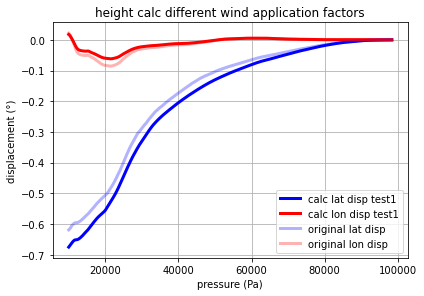

lat disp rmse:  0.03811364103208548
lon disp rmse:  0.01111911303521906
----------------
19.720000000000002 -155.06 19201130.0 230300.0


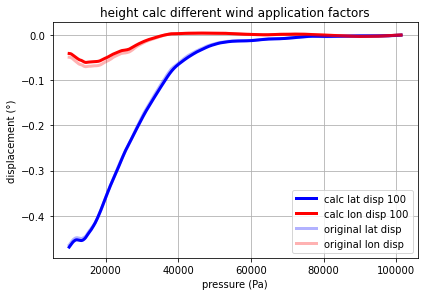

lat disp rmse:  0.002623125149234603
lon disp rmse:  0.00534624339437167


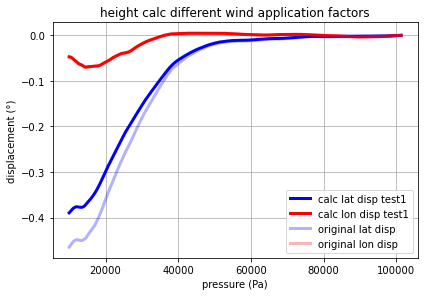

lat disp rmse:  0.041164973448724315
lon disp rmse:  0.0008345255111776474
----------------
32.900000000000006 -80.03 19201130.0 230600.0


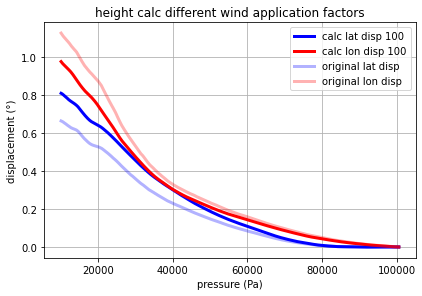

lat disp rmse:  0.08833341724511705
lon disp rmse:  0.08360920541004198


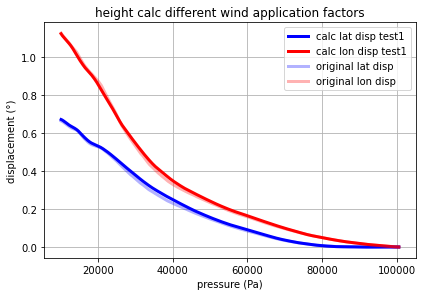

lat disp rmse:  0.010535613818602725
lon disp rmse:  0.010903465215251682
----------------
44.07 -103.21000000000001 19201130.0 230600.0


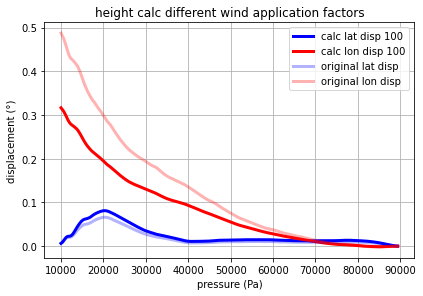

lat disp rmse:  0.008182114307794574
lon disp rmse:  0.0847961369476892


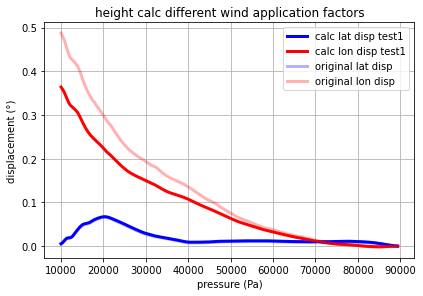

lat disp rmse:  0.0015001320390629334
lon disp rmse:  0.060836346295372025
----------------
not a valid station
-14.340000000000002 -170.72000000000003 19201130.0 230100.0


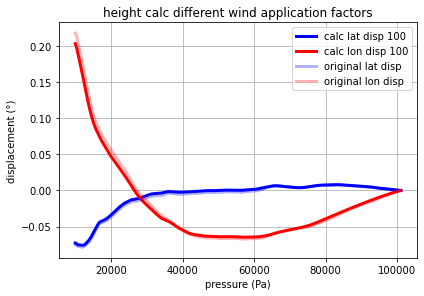

lat disp rmse:  0.002456614377010621
lon disp rmse:  0.006947480441044442


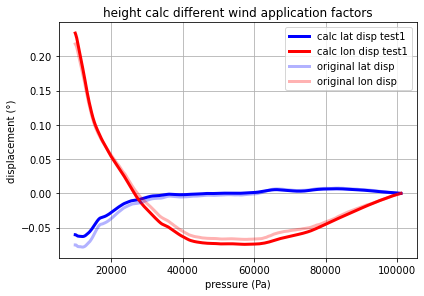

lat disp rmse:  0.0070327422962252915
lon disp rmse:  0.006743178888668186
----------------
40.77 -111.96000000000001 19201130.0 230600.0


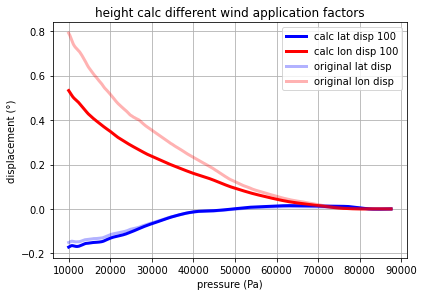

lat disp rmse:  0.010991304911267727
lon disp rmse:  0.1353575546979846


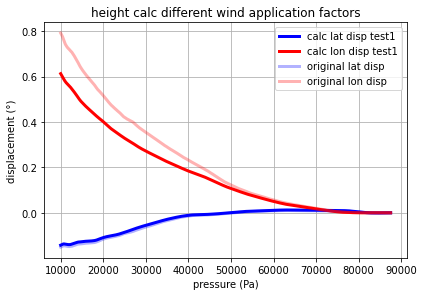

lat disp rmse:  0.005980429932055945
lon disp rmse:  0.09345746399272639
----------------
not a valid station
48.21 -106.63000000000001 19201130.0 230100.0


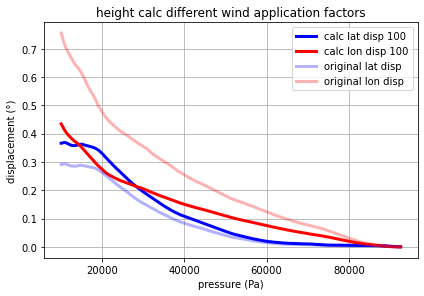

lat disp rmse:  0.045833274897638776
lon disp rmse:  0.16509777344390075


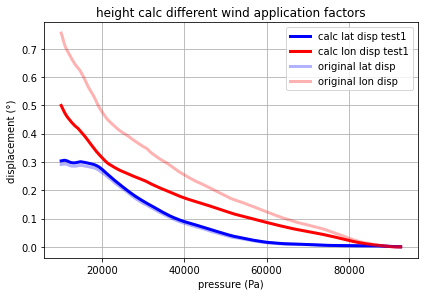

lat disp rmse:  0.0078247092477825
lon disp rmse:  0.13136386556728044
----------------
46.77 -100.76 19201130.0 230800.0


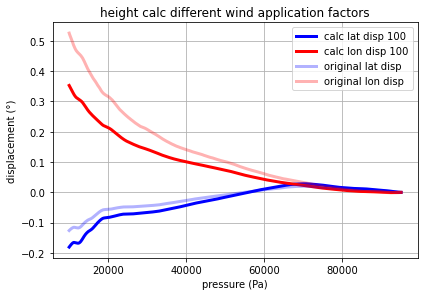

lat disp rmse:  0.02550056925444472
lon disp rmse:  0.08361217424793718


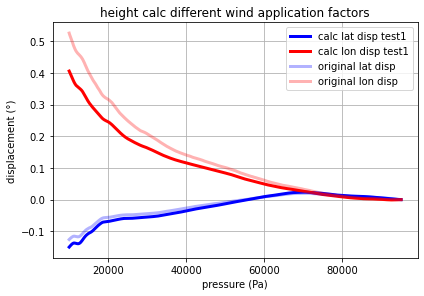

lat disp rmse:  0.011585466068138523
lon disp rmse:  0.05774089623526969
----------------
32.230000000000004 -110.96000000000001 19201130.0 230300.0


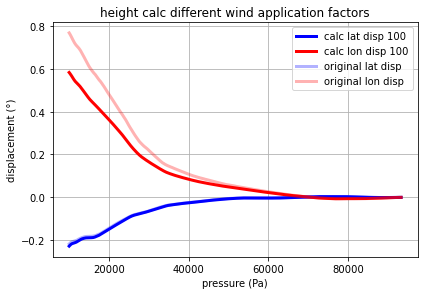

lat disp rmse:  0.0038873762397448903
lon disp rmse:  0.08943610655815072


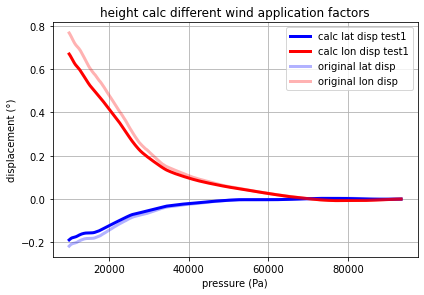

lat disp rmse:  0.01476743968359643
lon disp rmse:  0.048148841861988326
----------------
35.230000000000004 -111.82000000000001 19201130.0 231900.0


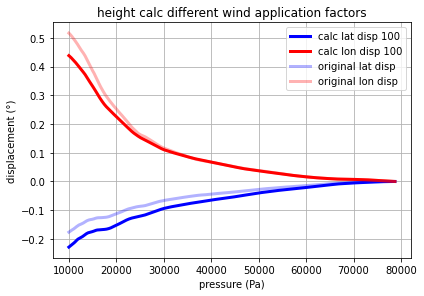

lat disp rmse:  0.031918939398148306
lon disp rmse:  0.03414615455159772


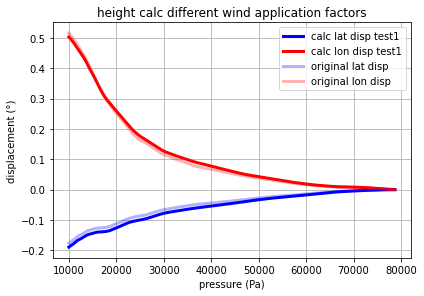

lat disp rmse:  0.010940469288386212
lon disp rmse:  0.00824662626537529
----------------
32.84 -97.30000000000001 19201130.0 230900.0


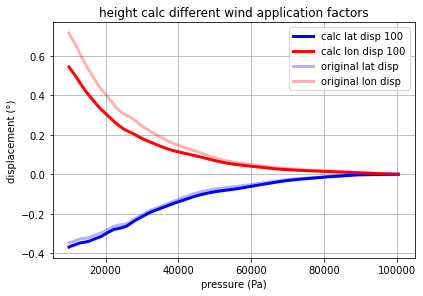

lat disp rmse:  0.013361798977312269
lon disp rmse:  0.07942363554147507


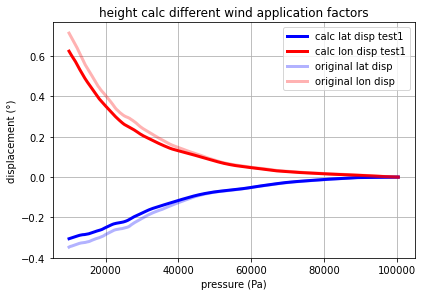

lat disp rmse:  0.024820432962397717
lon disp rmse:  0.04203070758099929
----------------
30.480000000000004 -81.7 19201130.0 231000.0


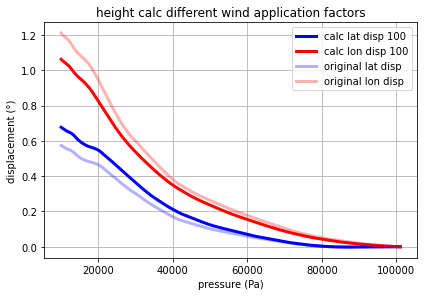

lat disp rmse:  0.06108306486845058
lon disp rmse:  0.0810971870201555


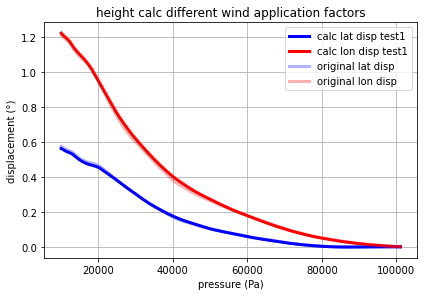

lat disp rmse:  0.006247760134748256
lon disp rmse:  0.011934453208665426
----------------
42.7 -83.47000000000001 19201130.0 230700.0


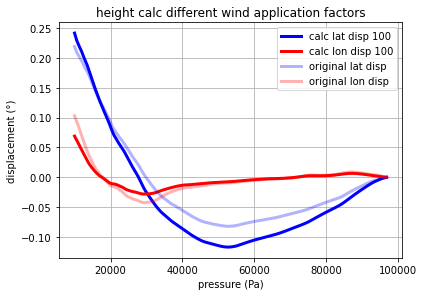

lat disp rmse:  0.02200549220548437
lon disp rmse:  0.01076776327565416


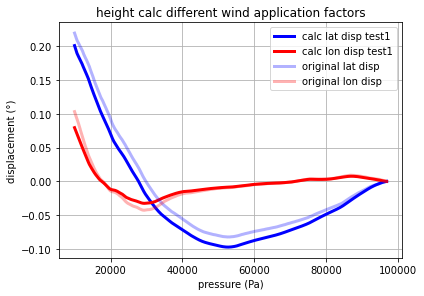

lat disp rmse:  0.01750070618517436
lon disp rmse:  0.007600975030297588
----------------
Latitude Displacement data set 1 - plev:  92500  RMSE:  0.0006332750190434415
Longitude Displacement data set 1 - plev:  92500  RMSE:  0.0007300168971222186
Latitude Displacement data set 2 - plev:  92500  RMSE:  0.0002888435918679502
Longitude Displacement data set 2 - plev:  92500  RMSE:  0.0004677612034592683
Latitude Displacement data set 1 - plev:  92500  RMS:  0.0006332750190434415
Longitude Displacement data set 1 - plev:  92500  RMS:  0.0007300168971222186
Latitude Displacement data set 2 - plev:  92500  RMS:  0.0002888435918679502
Longitude Displacement data set 2 - plev:  92500  RMS:  0.0004677612034592683
Latitude Displacement data set 1 - plev:  85000  RMSE:  0.002950703711295838
Longitude Displacement data set 1 - plev:  85000  RMSE:  0.0017986172742846566
Latitude Displacement data set 2 - plev:  85000  RMSE:  0.0012324650337717678
Longitude Displacement data set 2 - plev:  85000  RM

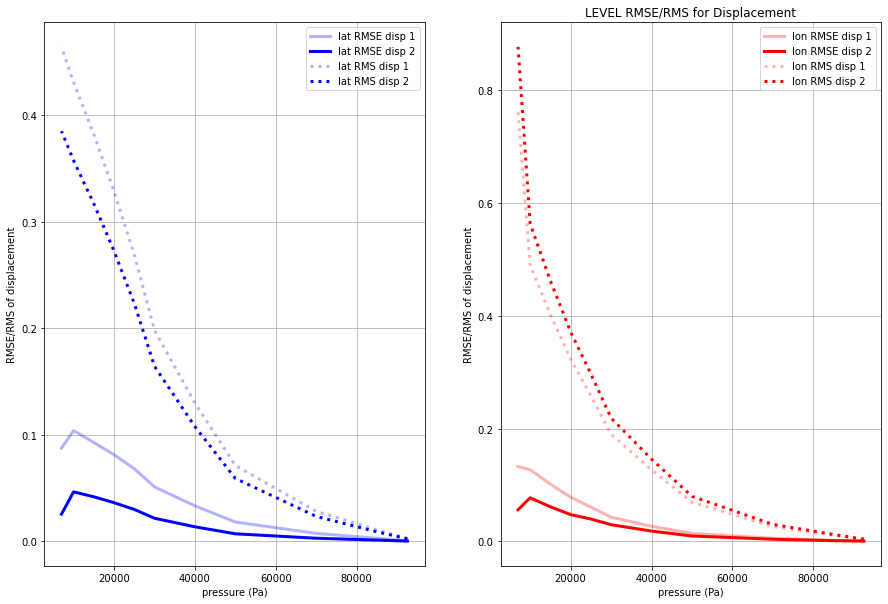

data set 1:  0.031918939398148306 0.06074310719153026
data set 2:  0.010623533352831574 0.024371368746628805


In [12]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()

# Testing

In [ ]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    old_rmse = 1
    older_rmse = 1
    fff = 1.0
    while True:
        alldata=''
        alldict=dict()

        bufrlist=[]
        tx=time.time()
    #     try:
        f = open(bufrfile)
        print(f)
        cnt = 0
        output = {}
        # loop over the messages in the file
        bc = 0


        rmse_sum_lat = []
        rmse_sum_lon = []
        rmse_sum_lat_1 = []
        rmse_sum_lon_1 = []
        rmse_sum_lat_2 = []
        rmse_sum_lon_2 = []

        while 1:
    #         try:
            # get handle for message
            bufr = codes_bufr_new_from_file(f)
            if bufr is None:
                break
            # we need to instruct ecCodes to expand all the descriptors
            # i.e. unpack the data section
            if codes_get_array(bufr,'dataSubCategory')[0]!=109:
                codes_release(bufr)
                continue
            codes_set(bufr, 'unpack', 1)
            # get all the timePeriods
            iterid = codes_bufr_keys_iterator_new(bufr)

            # loop over the keys
            #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
                ##print (codes_get_array(bufr,'dataSubCategory')[0])
                #codes_release(bufr)
                #continue
            hires=False
            while codes_bufr_keys_iterator_next(iterid):

                # print key name
                keyname = codes_bufr_keys_iterator_get_name(iterid)
    #             print(keyname,codes_get_array(bufr,keyname))
                #if keyname in ['#1#blockNumber','#1#stationNumber']:
                    #print (keyname,codes_get_array(bufr,keyname))
                if 'latitudeDisplacement' in keyname:
                    hires=True
            if not hires:
                codes_bufr_keys_iterator_delete(iterid)
                continue
            ## delete the key iterator
            codes_bufr_keys_iterator_delete(iterid)
            output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
            output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
            output['pressure'] = codes_get_array(bufr, "pressure")
            output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
            output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
            output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
            output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
            output['airTemperature'] = codes_get_array(bufr, "airTemperature")
            dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
            output['windDirection'] = codes_get_array(bufr, "windDirection")
            output['windSpeed'] = codes_get_array(bufr, "windSpeed")
            output['lat'] = codes_get(bufr, "latitude")
            output['lon'] = codes_get(bufr, "longitude")
            output['alt'] = float(codes_get(bufr, "heightOfStation"))
            output['blockNumber'] = codes_get(bufr, "blockNumber")
            output['stationNumber'] = codes_get(bufr, "stationNumber")
            try:
                data = pd.DataFrame.from_dict(output)
                cont = True
            except:
                cont = False
            if cont:
                if data.pressure[0] < 40000:
                    u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
                    data['u'] = u
                    v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
                    data['v'] = v
                    data = data[data.airTemperature < 350]
                    data = data[data.airTemperature > 180]

                    true_latd = data.latitudeDisplacement
                    true_lond = data.longitudeDisplacement


                    lat_displacement_100, lon_displacement_100 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), u_factor=0.83, v_factor = fff)

                    rmse_sum_lat.append(np.sqrt(np.nanmean((np.array(lat_displacement_100)-true_latd)**2)))
                    rmse_sum_lon.append(np.sqrt(np.nanmean((np.array(lon_displacement_100)-true_lond)**2)))

                    bc += 1
    #         except:
    #             pass
            if bc > 100: #if bc > 30:
                break
        print(fff)
        print('data set 0: ',np.median(rmse_sum_lat), np.median(rmse_sum_lon))
        if (old_rmse < np.median(rmse_sum_lon)) and (older_rmse < np.median(rmse_sum_lon)):
            break
        else:
            older_rmse = old_rmse
            old_rmse = np.median(rmse_sum_lon)
            fff += 0.01
        
    return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


In [ ]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()

In [ ]:
0.83
data set 0:  0.00991811611498853 0.07403057705528218

1.15
data set 0:  0.009949274964413392 0.03332059666137682

# Height testing

In [ ]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()


In [ ]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    while 1:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
            ##print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

            # print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#             print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        return output


In [ ]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()


In [ ]:
data = pd.DataFrame.from_dict(out)
u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
data['u'] = u
v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
data['v'] = v
data = data[data.airTemperature < 350]
data = data[data.airTemperature > 180]
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
data


---
---

In [ ]:
reduced = reduced.reset_index()

In [ ]:
t = reduced.airTemperature
p = reduced.pressure
for i in range(len(reduced)):
    if i != 0:
        # from: https://www.cesm.ucar.edu/models/cesm1.1/cesm/cesmBbrowser/html_code/cam/tropopause.F90.html
        SHR_CONST_AVOGAD  = 6.02214e26
        SHR_CONST_BOLTZ   = 1.38065e-23
        SHR_CONST_MWDAIR  = 28.966
        SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
        SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
        rair = SHR_CONST_RDAIR
        
        SHR_CONST_G       = 9.80616
        gravit = SHR_CONST_G
        
        SHR_CONST_CPDAIR  = 1.00464e3
        cappa        = (SHR_CONST_RGAS/SHR_CONST_MWDAIR)/SHR_CONST_CPDAIR
        cnst_kap = cappa

        cnst_faktor = -gravit/rair
        cnst_ka1    = cnst_kap - 1.

        # dt/dz
        pmk= .5 * (p[i-1]**cnst_kap+p[i]**cnst_kap)
        pm = pmk**(1/cnst_kap)               
        a = (t[i-1]-t[i])/(p[i-1]**cnst_kap-p[i]**cnst_kap)
        b = t[i]-(a*p[i]**cnst_kap)
        tm = a * pmk + b               
        dtdp = a * cnst_kap * (pm**cnst_ka1)
        dtdz = cnst_faktor*dtdp*pm/tm
        print(dtdz)
        print(-9.80665/287.053* (reduced.airTemperature[i-1]-reduced.airTemperature[i])/((reduced.pressure[i-1] - (reduced.pressure[i]) * reduced.pressure[i]/reduced.airTemperature[i])))
        print((3300 / 9.8 / 1000 * 1e9) / (reduced.airTemperature[i-1]-reduced.airTemperature[i])/((reduced.pressure[i-1] - reduced.pressure[i])))
        print((reduced.airTemperature[i-1]-reduced.airTemperature[i])/(np.log(reduced.pressure[i-1] - reduced.pressure[i])))
        print((reduced.airTemperature[i-1]-reduced.airTemperature[i])/(np.log(reduced.pressure[i-1]) - np.log(reduced.pressure[i])))
        print((reduced.airTemperature[i]-reduced.airTemperature[i-1])/(reduced.geopotentialHeight[i] - reduced.geopotentialHeight[i-1]))
        print('---')
 # /1000? K/m -> K/km

In [ ]:
calc_height(np.array(data.airTemperature), np.array(data.pressure), 'pthf')[-1]

In [ ]:
data = data.reset_index()

In [ ]:
z= calc_height(data.airTemperature, data.pressure, variant='pthf', jump=False)
z2= calc_height(data.airTemperature, data.pressure, variant='pthf', jump=True)
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

# plt.plot(data.pressure,z,label='z')
# plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure[:-50],np.array(z[:-50])-np.array(z2[:-50]),label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [ ]:
data2 = data[np.array(z) > 20000000]

In [ ]:
data2

In [ ]:
data[data.geopotentialHeight < 18479]

In [ ]:
data2 = data2.reset_index()

In [ ]:
for i in range(len(data2)):
    if i != 0:
        print((np.log(data2.pressure[i-1] - data2.pressure[i])))
        print((np.log(data2.pressure[i-1]) - np.log(data2.pressure[i])))
        print((np.log(data2.pressure[i]) - np.log(data2.pressure[i-1])))

        print((data2.geopotentialHeight[i-1] - data2.geopotentialHeight[i]))
        print('---')
 # /1000? K/m -> K/km

In [ ]:
z[-16]

In [ ]:
z = calc_height(data.airTemperature, data.pressure, 'pthf', jump = False)
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [ ]:
z = calc_height(np.array(reduced.airTemperature), np.array(reduced.pressure), 'pthf')
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(reduced.pressure,z,label='z')
plt.plot(reduced.pressure,reduced.geopotentialHeight,label='geop.h.')
plt.plot(reduced.pressure,reduced.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [ ]:
z = calc_height(data.airTemperature, data.pressure, 'ithf')
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [ ]:
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
z = calc_height(np.array(reduced.airTemperature), np.array(reduced.pressure))
vec_expint = numpy.vectorize(expint)
z = vec_expint(z)

plt.plot(reduced.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

---
---

In [ ]:
lat = data.lat.iloc[0]
lon = data.lon.iloc[0]
print(lat, lon)
print(transport(lat, lon, [111,-111],[0,0]))

print(transport(lat, lon, 100,0))
print(transport(lat, lon, -100,0))

print(transport(lat, lon, 0,100))
print(transport(lat, lon, 0,-100))

---
---

In [ ]:
lat_displacement, lon_displacement = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature))

In [ ]:
plt.plot(data.pressure,np.array(lat_displacement),label='calc lat disp')
plt.plot(data.pressure,np.array(lon_displacement),label='calc lon disp')
plt.plot(data.pressure,data.latitudeDisplacement,label='original lat disp')
plt.plot(data.pressure,data.longitudeDisplacement,label='original lon disp')

plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [ ]:
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
lat_displacement, lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))

In [ ]:
plt.plot(reduced.pressure,lat_displacement,label='calc lat disp')
plt.plot(reduced.pressure,lon_displacement,label='calc lon disp')
plt.plot(reduced.pressure,reduced.latitudeDisplacement,label='original lat disp')
plt.plot(reduced.pressure,reduced.longitudeDisplacement,label='original lon disp')

plt.title('height calc')
plt.legend()
plt.grid()
plt.show()